<a href="https://colab.research.google.com/github/aureavaleria/DataBalancing-Research/blob/main/Vers%C3%A3o_1_(treino_80_e_teste_20_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Machine learning for predicting liver and/or lung metastasis in colorectal cancer: A retrospective study based on the SEER database***

Este estudo propõe um modelo de aprendizado de máquina para prever o risco de metástase hepática e/ou pulmonar em pacientes com câncer colorretal (CRC). A partir da base de dados SEER, foram extraídos dados aproximadamente 53 mil pacientes com diagnóstico patológico de CRC entre 2010 e 2015, desenvolvendo sete modelos de algoritmos(Decision tree, Randon Forest, Naive Bayes,  KNN,XGBoost, Gradient Boosting.

## 1. Importação das Bibliotecas

Todas as ferramentas necessárias para manipulação de dados, balanceamento de classes, construção de modelos e visualização de resultados são importadas.

In [ ]:
# Importação das bibliotecas necessárias
# Este bloco importa todas as bibliotecas que serão usadas no processamento dos dados,
# no balanceamento das classes, na definição dos modelos e na visualização dos resultados.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score

## 2. Carregamento e Pré-processamento dos Dados

* O dataset, que inclui informações clínicas e demográficas de pacientes com
câncer colorretal, é carregado de um arquivo CSV.
* As variáveis preditoras incluem características como idade, sexo, tipo histológico, tamanho do tumor e outros fatores clínicos importantes.
* A variável alvo indica se o paciente apresenta metástase no fígado ou pulmão.

In [ ]:
# Carregar o dataset
df = pd.read_csv('https://raw.githubusercontent.com/aureavaleria/dataset/refs/heads/main/export.csv')

# Verificar se existem valores faltantes (NaN) e exibir quantos valores faltantes existem por coluna
print("Valores faltantes por coluna:\n", df.isnull().sum())

# Remover as linhas com valores faltantes
df.dropna(inplace=True)

# Definir as variáveis preditoras (X)
X = df[['Age recode with <1 year olds', 'Sex', 'Race recode (White, Black, Other)',
        'Histologic Type ICD-O-3', 'Grade Recode (thru 2017)', 'Primary Site',
        'Derived AJCC T, 7th ed (2010-2015)', 'Derived AJCC N, 7th ed (2010-2015)',
        'CS tumor size (2004-2015)', 'CEA Pretreatment Interpretation Recode (2010+)',
        'Tumor Deposits Recode (2010+)', 'Marital status at diagnosis',
        'Origin recode NHIA (Hispanic, Non-Hisp)']]

# Definir as variáveis alvo: Metástase no fígado e no pulmão
y_liver = df['SEER Combined Mets at DX-liver (2010+)']
y_lung = df['SEER Combined Mets at DX-lung (2010+)']

# Concatenar as variáveis alvo 'y_liver' e 'y_lung' em um DataFrame 'y' para problemas multi-label
y = pd.concat([y_liver, y_lung], axis=1)

# Aplicar codificação a variáveis categóricas em 'X' usando LabelEncoder, para prepará-las para o modelo
for col in X.columns:
    if X[col].dtype == 'object':  # Verifica se a coluna é categórica (strings)
        X[col] = LabelEncoder().fit_transform(X[col])

# Função para combinar as informações de metástase hepática e pulmonar em uma coluna binária 'Binary Mets'
# (0 = sem metástase, 1 = com metástase)
def combine_mets_binary(row):
    if row['SEER Combined Mets at DX-liver (2010+)'] == 'Yes' or row['SEER Combined Mets at DX-lung (2010+)'] == 'Yes':
        return 1  # Com metástase
    else:
        return 0  # Sem metástase

# Aplicar a função para criar a nova coluna binária 'Binary Mets' em 'y'
y['Binary Mets'] = y.apply(combine_mets_binary, axis=1)

# Verificar se 'X' e 'y' têm o mesmo número de amostras
print(f"Tamanho de X: {len(X)}")
print(f"Tamanho de y: {len(y)}")

# Salvar o DataFrame 'y' em um arquivo CSV para referência futura ou análise adicional
y.to_csv('/content/Y.csv')

Valores faltantes por coluna:
 Patient ID                                         0
Age recode with <1 year olds                       0
Sex                                                0
Race recode (White, Black, Other)                  0
Histologic Type ICD-O-3                            0
Grade Recode (thru 2017)                           0
Primary Site                                       0
Derived AJCC T, 7th ed (2010-2015)                 0
Derived AJCC N, 7th ed (2010-2015)                 0
CS tumor size (2004-2015)                          0
CEA Pretreatment Interpretation Recode (2010+)     0
Tumor Deposits Recode (2010+)                      0
Marital status at diagnosis                        0
Origin recode NHIA (Hispanic, Non-Hisp)            0
SEER Combined Mets at DX-lung (2010+)             15
SEER Combined Mets at DX-liver (2010+)            12
SEER Combined Mets at DX-bone (2010+)             14
ICD-O-3 Hist/behav                                 0
ICD-O-3 Hist/be

<ipython-input-3-7e7566ce27fd>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])
<ipython-input-3-7e7566ce27fd>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])
<ipython-input-3-7e7566ce27fd>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

Tamanho de X: 53448
Tamanho de y: 53448


## 3. Escalonamento e Balanceamento dos Dados

Para lidar com o desbalanceamento entre classes (pacientes com e sem metástases), técnicas de balanceamento como SMOTE (para aumentar as amostras da classe minoritária) e undersampling (para reduzir a classe majoritária) são aplicadas.
Os dados são escalados para garantir que as variáveis sejam comparáveis em magnitude.

In [ ]:
# Dividir o dataset em conjuntos de treinamento e teste
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y['Binary Mets'], test_size=0.2, random_state=42, stratify=y['Binary Mets']
)

# Escalonamento dos dados
# Utilizar as variáveis corretas (X_train_full e y_train_full)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

# Aplicar undersampling
under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train_scaled, y_train_full)

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_full)

print("Conjuntos balanceados criados com sucesso!")



Conjuntos balanceados criados com sucesso!


## 4. Definição dos Modelos

* Diversos modelos de aprendizado de máquina são configurados, incluindo Random Forest, SVM, Naive Bayes, Gradient Boosting, e outros.
* Esses modelos são treinados em dados balanceados para garantir previsões justas e reduzir o risco de overfitting.

In [ ]:
# Definição dos modelos
# Este bloco define os algoritmos de aprendizado de máquina que serão treinados e avaliados.
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

## 5. Geração e Visualização das Curvas ROC


Processando o modelo: Random Forest


<ipython-input-7-a056f2621d3e>:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Random")


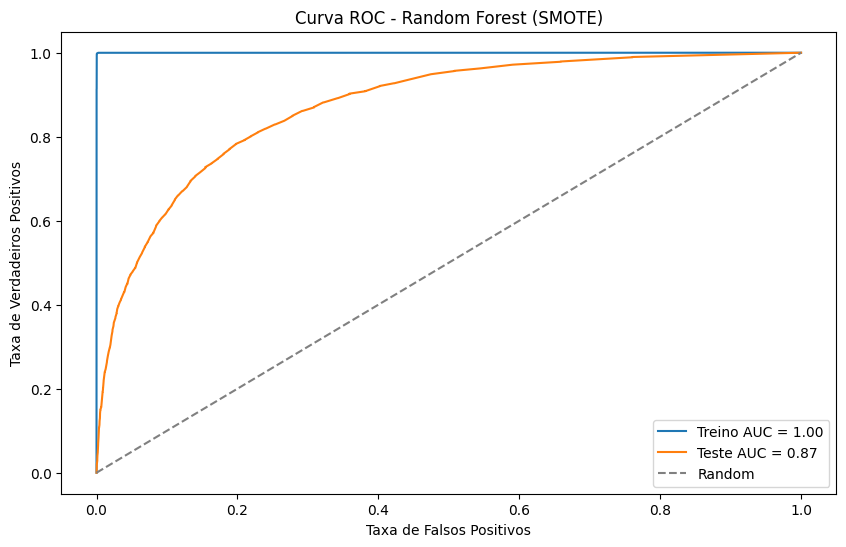

<ipython-input-7-a056f2621d3e>:91: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Random")


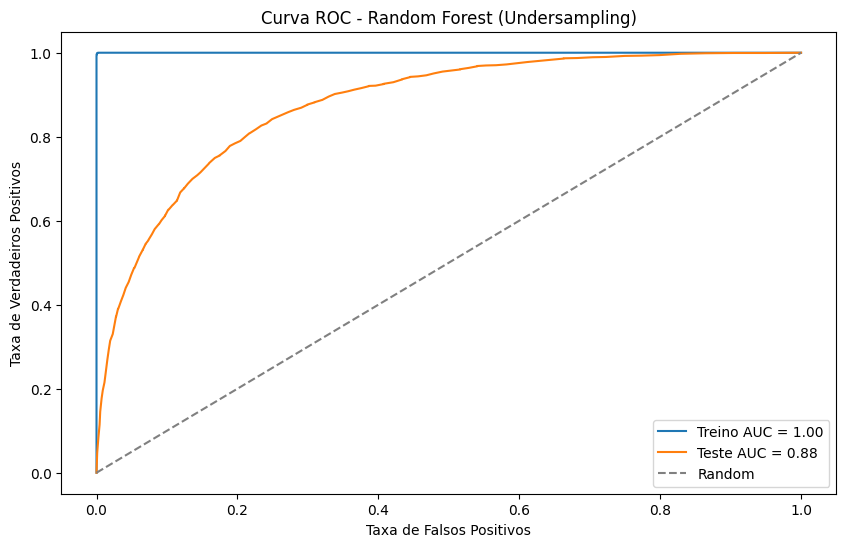


Processando o modelo: Decision Tree


<ipython-input-7-a056f2621d3e>:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Random")


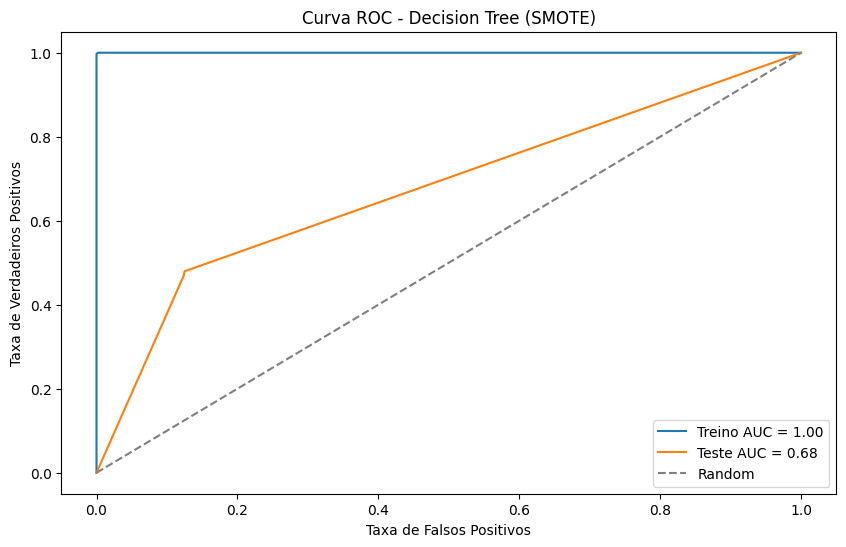

<ipython-input-7-a056f2621d3e>:91: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Random")


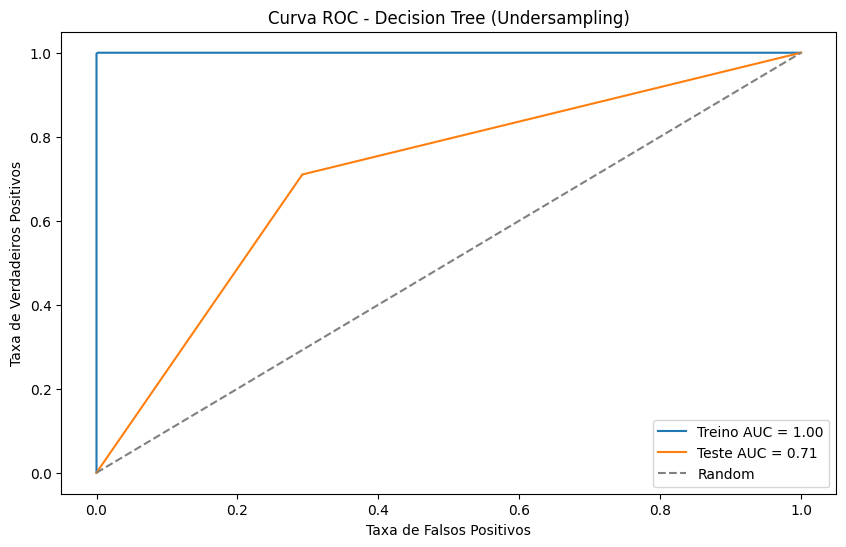


Processando o modelo: SVM


<ipython-input-7-a056f2621d3e>:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Random")


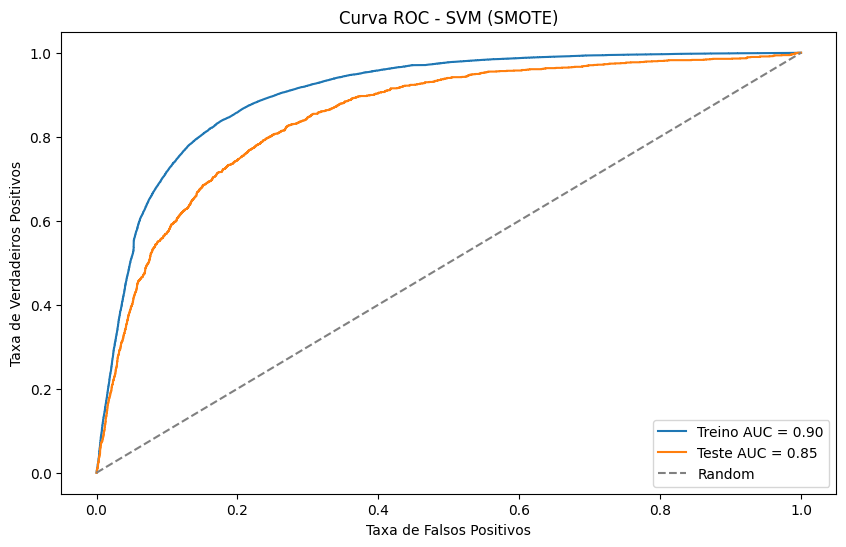

<ipython-input-7-a056f2621d3e>:91: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Random")


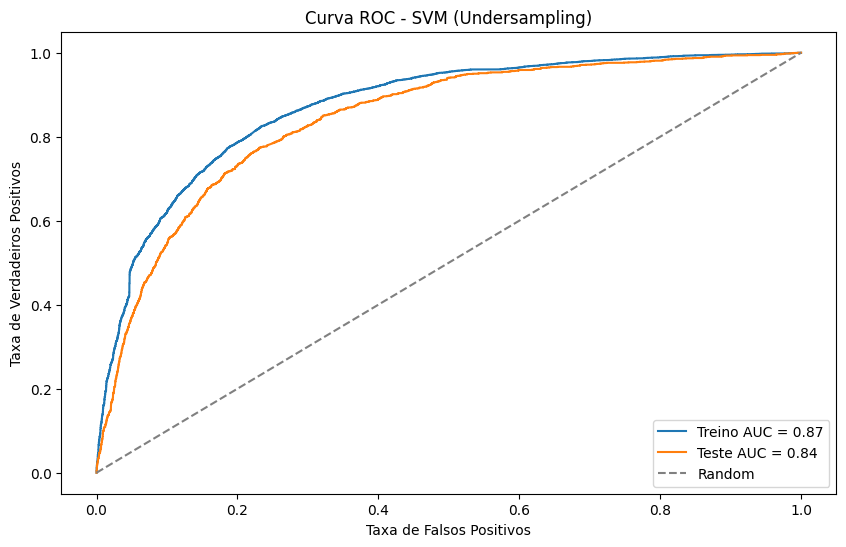


Processando o modelo: Naive Bayes


<ipython-input-7-a056f2621d3e>:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Random")


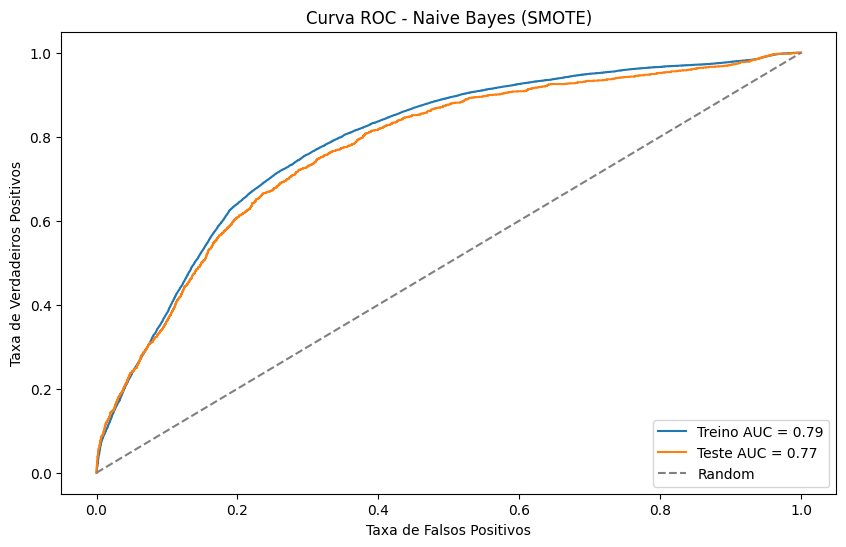

<ipython-input-7-a056f2621d3e>:91: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Random")


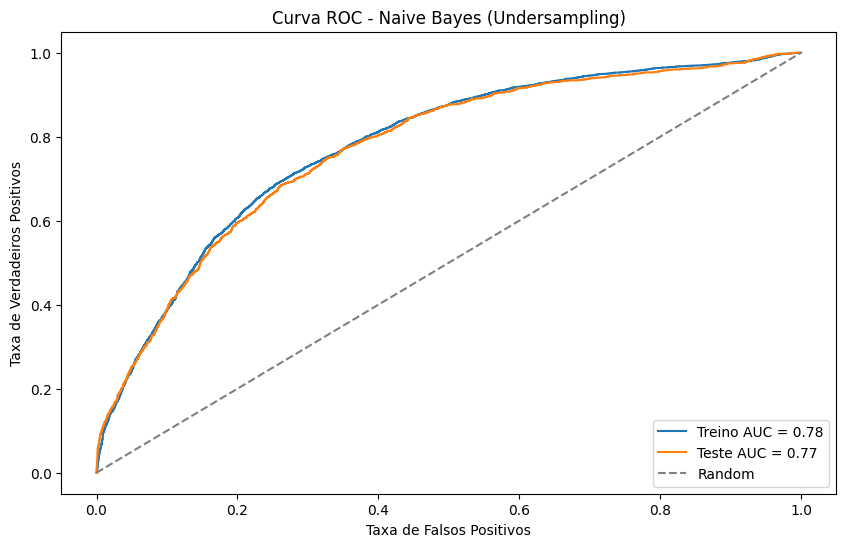


Processando o modelo: KNN


<ipython-input-7-a056f2621d3e>:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Random")


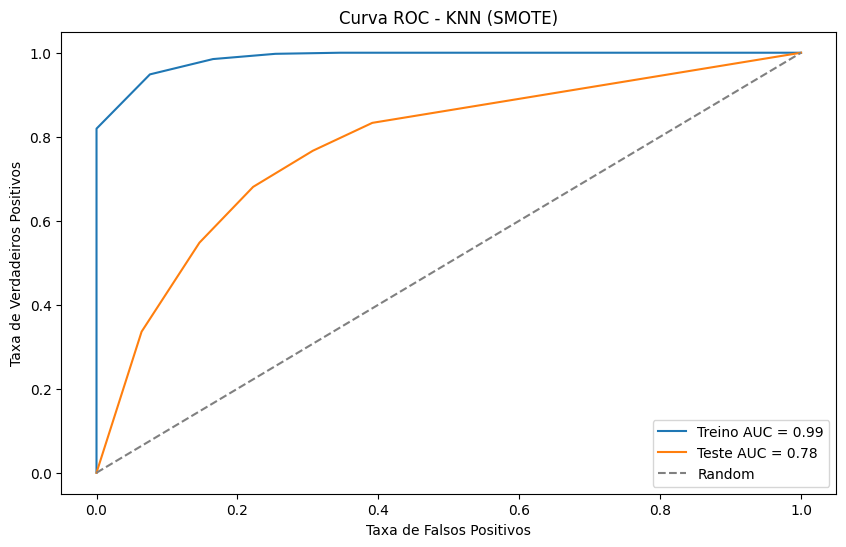

<ipython-input-7-a056f2621d3e>:91: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Random")


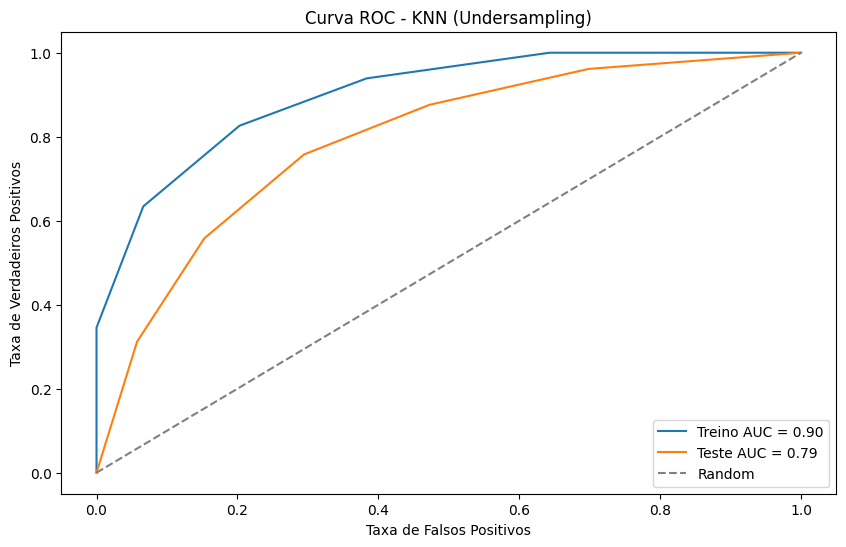


Processando o modelo: XGBoost


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:06:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-7-a056f2621d3e>:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Random")


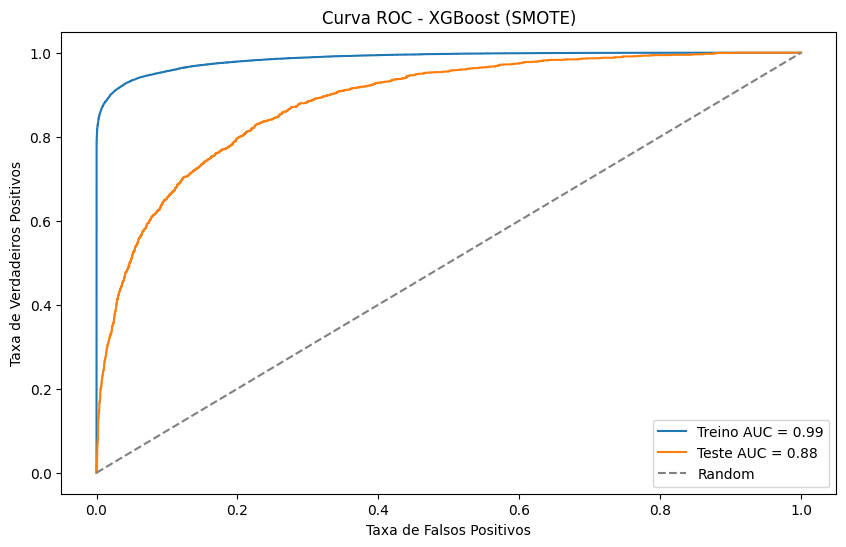

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:06:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-7-a056f2621d3e>:91: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Random")


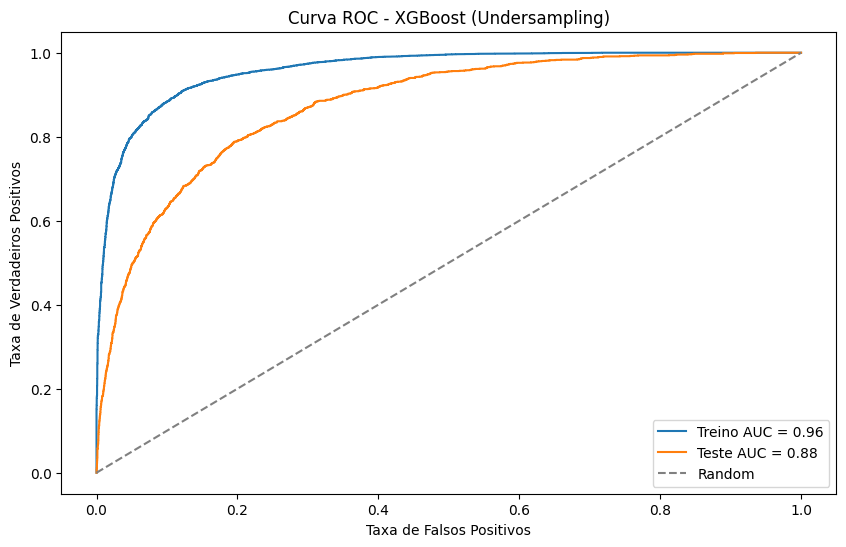


Processando o modelo: Gradient Boosting


<ipython-input-7-a056f2621d3e>:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Random")


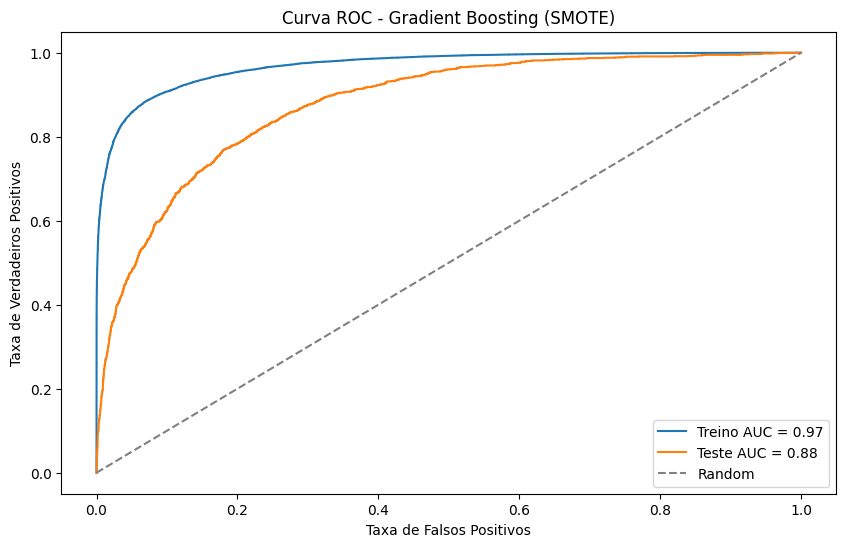

<ipython-input-7-a056f2621d3e>:91: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Random")


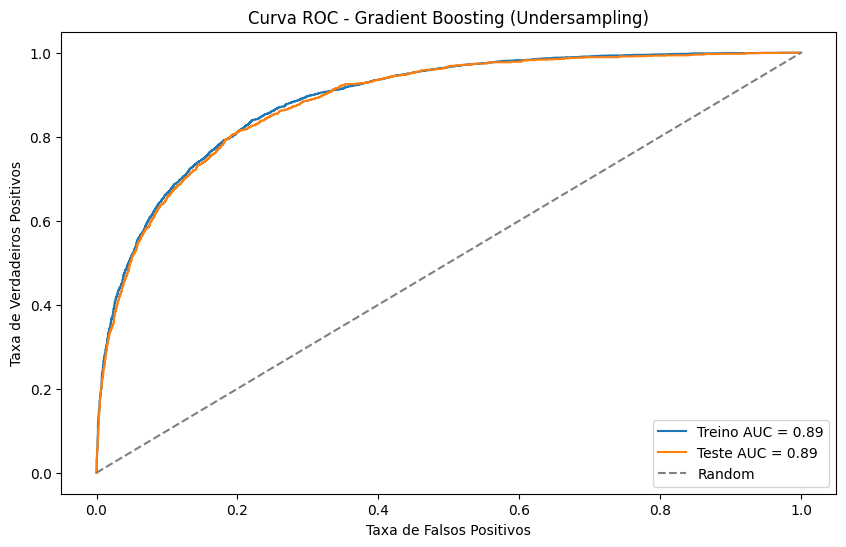


Resultados para SMOTE:
              Modelo  Especificidade  Precisão  Sensibilidade (Recall)  \
0      Random Forest        0.951586  0.628788                0.472486   
1      Decision Tree        0.875837  0.398404                0.473751   
2                SVM        0.784389  0.381417                0.765971   
3        Naive Bayes        0.744319  0.315805                0.679949   
4                KNN        0.777692  0.346985                0.680582   
5            XGBoost        0.955868  0.655527                0.483871   
6  Gradient Boosting        0.917225  0.553053                0.590133   

   F1-Score  AUC (ROC)      AUPR  
0  0.539545   0.873266  0.583825  
1  0.432823   0.676936  0.267407  
2  0.509251   0.849714  0.492191  
3  0.431294   0.773155  0.393518  
4  0.459633   0.780380  0.358318  
5  0.556769   0.883392  0.621342  
6  0.570991   0.877623  0.603657  

Resultados para Undersampling:
              Modelo  Especificidade  Precisão  Sensibilidade (Recall) 

In [ ]:
# Importações necessárias
from sklearn.metrics import (
    confusion_matrix, f1_score, roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve
)
import pandas as pd
import matplotlib.pyplot as plt

# Avaliação dos modelos para SMOTE e Undersampling
results_smote = []  # Resultados para SMOTE
results_undersampling = []  # Resultados para Undersampling

for model_name, model in models.items():
    print(f"\nProcessando o modelo: {model_name}")

    # **TREINAMENTO COM SMOTE**
    model.fit(X_train_smote, y_train_smote)
    y_train_smote_proba = model.predict_proba(X_train_smote)[:, 1]
    y_test_smote_proba = model.predict_proba(X_test_scaled)[:, 1]
    y_test_smote_pred = model.predict(X_test_scaled)

    # Métricas SMOTE
    cm_smote_test = confusion_matrix(y_test, y_test_smote_pred)
    tn_smote, fp_smote, fn_smote, tp_smote = cm_smote_test.ravel()
    specificity_smote = tn_smote / (tn_smote + fp_smote)
    precision_smote = tp_smote / (tp_smote + fp_smote)
    recall_smote = tp_smote / (tp_smote + fn_smote)
    f1_smote = f1_score(y_test, y_test_smote_pred)
    auc_smote = roc_auc_score(y_test, y_test_smote_proba)
    aupr_smote = average_precision_score(y_test, y_test_smote_proba)

    # Adicionar resultados SMOTE
    results_smote.append({
        "Modelo": model_name,
        "Especificidade": specificity_smote,
        "Precisão": precision_smote,
        "Sensibilidade (Recall)": recall_smote,
        "F1-Score": f1_smote,
        "AUC (ROC)": auc_smote,
        "AUPR": aupr_smote
    })

    # Curva ROC (SMOTE)
    fpr_train_smote, tpr_train_smote, _ = roc_curve(y_train_smote, y_train_smote_proba)
    fpr_test_smote, tpr_test_smote, _ = roc_curve(y_test, y_test_smote_proba)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train_smote, tpr_train_smote, label=f"Treino AUC = {roc_auc_score(y_train_smote, y_train_smote_proba):.2f}")
    plt.plot(fpr_test_smote, tpr_test_smote, label=f"Teste AUC = {auc_smote:.2f}")
    plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Random")
    plt.title(f"Curva ROC - {model_name} (SMOTE)")
    plt.xlabel("Taxa de Falsos Positivos")
    plt.ylabel("Taxa de Verdadeiros Positivos")
    plt.legend(loc="lower right")
    plt.show()

    # **TREINAMENTO COM UNDERSAMPLING**
    model.fit(X_train_under, y_train_under)
    y_train_under_proba = model.predict_proba(X_train_under)[:, 1]
    y_test_under_proba = model.predict_proba(X_test_scaled)[:, 1]
    y_test_under_pred = model.predict(X_test_scaled)

    # Métricas Undersampling
    cm_under_test = confusion_matrix(y_test, y_test_under_pred)
    tn_under, fp_under, fn_under, tp_under = cm_under_test.ravel()
    specificity_under = tn_under / (tn_under + fp_under)
    precision_under = tp_under / (tp_under + fp_under)
    recall_under = tp_under / (tp_under + fn_under)
    f1_under = f1_score(y_test, y_test_under_pred)
    auc_under = roc_auc_score(y_test, y_test_under_proba)
    aupr_under = average_precision_score(y_test, y_test_under_proba)

    # Adicionar resultados Undersampling
    results_undersampling.append({
        "Modelo": model_name,
        "Especificidade": specificity_under,
        "Precisão": precision_under,
        "Sensibilidade (Recall)": recall_under,
        "F1-Score": f1_under,
        "AUC (ROC)": auc_under,
        "AUPR": aupr_under
    })

    # Curva ROC (Undersampling)
    fpr_train_under, tpr_train_under, _ = roc_curve(y_train_under, y_train_under_proba)
    fpr_test_under, tpr_test_under, _ = roc_curve(y_test, y_test_under_proba)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train_under, tpr_train_under, label=f"Treino AUC = {roc_auc_score(y_train_under, y_train_under_proba):.2f}")
    plt.plot(fpr_test_under, tpr_test_under, label=f"Teste AUC = {auc_under:.2f}")
    plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Random")
    plt.title(f"Curva ROC - {model_name} (Undersampling)")
    plt.xlabel("Taxa de Falsos Positivos")
    plt.ylabel("Taxa de Verdadeiros Positivos")
    plt.legend(loc="lower right")
    plt.show()

# **GERAR RELATÓRIOS**
results_smote_df = pd.DataFrame(results_smote)
results_undersampling_df = pd.DataFrame(results_undersampling)

print("\nResultados para SMOTE:")
print(results_smote_df)

print("\nResultados para Undersampling:")
print(results_undersampling_df)


In [ ]:
# Avaliação dos modelos para SMOTE e Validação Externa
results_smote = []  # Resultados para SMOTE
external_results = []  # Resultados para Validação Externa

# Carregar base de dados externa
external_data = pd.read_csv('https://raw.githubusercontent.com/aureavaleria/dataset/refs/heads/main/bdsintetico.csv')

# Definir as colunas de features (variáveis preditoras) e a coluna-alvo
features = [
    'Age (years)', 'Gender', 'Race', 'Hispanic', 'Marital status',
    'Histological type', 'Grade', 'Primary tumor site', 'T stage',
    'N stage', 'Tumor size (cm)', 'CEA', 'Tumor deposits'
]
target = 'Liver and/or lung metastasis'

# Criar as variáveis X (features) e y (target)
X_external = external_data[features]
y_external = external_data[target]

# Verificar as dimensões das variáveis criadas
print(f"Dimensões de X_external: {X_external.shape}")
print(f"Dimensões de y_external: {y_external.shape}")
# Pré-processamento da base externa
# Aqui é necessário garantir que o scaler foi ajustado nos dados de treino previamente

# Escalonamento dos dados da base externa
X_external_scaled = scaler.transform(X_external)  # Aplicar o mesmo scaler usado nos dados de treinamento

# Verificar as dimensões dos dados escalonados
print(f"Dimensões de X_external_scaled: {X_external_scaled.shape}")

for model_name, model in models.items():
    print(f"\nProcessando o modelo: {model_name}")

    # **TREINAMENTO COM SMOTE**
    model.fit(X_train_smote, y_train_smote)
    y_train_smote_proba = model.predict_proba(X_train_smote)[:, 1]
    y_test_smote_proba = model.predict_proba(X_test_scaled)[:, 1]
    y_test_smote_pred = model.predict(X_test_scaled)

    # Métricas SMOTE
    cm_smote_test = confusion_matrix(y_test, y_test_smote_pred)
    tn_smote, fp_smote, fn_smote, tp_smote = cm_smote_test.ravel()
    specificity_smote = tn_smote / (tn_smote + fp_smote)
    precision_smote = tp_smote / (tp_smote + fp_smote)
    recall_smote = tp_smote / (tp_smote + fn_smote)
    f1_smote = f1_score(y_test, y_test_smote_pred)
    auc_smote = roc_auc_score(y_test, y_test_smote_proba)
    aupr_smote = average_precision_score(y_test, y_test_smote_proba)

    # Adicionar resultados SMOTE
    results_smote.append({
        "Modelo": model_name,
        "Especificidade": specificity_smote,
        "Precisão": precision_smote,
        "Sensibilidade (Recall)": recall_smote,
        "F1-Score": f1_smote,
        "AUC (ROC)": auc_smote,
        "AUPR": aupr_smote
    })

    # Curva ROC (SMOTE)
    fpr_test_smote, tpr_test_smote, _ = roc_curve(y_test, y_test_smote_proba)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr_test_smote, tpr_test_smote, label=f"Teste AUC = {auc_smote:.2f}")
    plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Random")
    plt.title(f"Curva ROC - {model_name} (SMOTE)")
    plt.xlabel("Taxa de Falsos Positivos")
    plt.ylabel("Taxa de Verdadeiros Positivos")
    plt.legend(loc="lower right")
    plt.show()

    # **VALIDAÇÃO NA BASE EXTERNA**
    y_external_proba = model.predict_proba(X_external_scaled)[:, 1]
    y_external_pred = model.predict(X_external_scaled)

    # Métricas para a base externa
    cm_external = confusion_matrix(y_external, y_external_pred)
    tn_external, fp_external, fn_external, tp_external = cm_external.ravel()
    specificity_external = tn_external / (tn_external + fp_external)
    precision_external = tp_external / (tp_external + fp_external)
    recall_external = tp_external / (tp_external + fn_external)
    f1_external = f1_score(y_external, y_external_pred)
    auc_external = roc_auc_score(y_external, y_external_proba)
    aupr_external = average_precision_score(y_external, y_external_proba)

    # Adicionar resultados
    external_results.append({
        "Modelo": model_name,
        "Especificidade": specificity_external,
        "Precisão": precision_external,
        "Sensibilidade (Recall)": recall_external,
        "F1-Score": f1_external,
        "AUC (ROC)": auc_external,
        "AUPR": aupr_external
    })

    # Curva ROC para a base externa
    fpr_external, tpr_external, _ = roc_curve(y_external, y_external_proba)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr_external, tpr_external, label=f"Base Externa AUC = {auc_external:.2f}")
    plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Random")
    plt.title(f"Curva ROC - {model_name} (Base Externa)")
    plt.xlabel("Taxa de Falsos Positivos")
    plt.ylabel("Taxa de Verdadeiros Positivos")
    plt.legend(loc="lower right")
    plt.show()

# Gerar relatórios
results_smote_df = pd.DataFrame(results_smote)
external_results_df = pd.DataFrame(external_results)

print("\nResultados para SMOTE:")
print(results_smote_df)

print("\nResultados para a base externa:")
print(external_results_df)


Dimensões de X_external: (196, 13)
Dimensões de y_external: (196,)


NameError: name 'X_train' is not defined